<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Сделано на основе курса "Построение выводов по данным" специализации "Машинное обучение и анализ данных" Яндекса и МФТИ

# <center>Тема 9. Анализ временных рядов в Python</center>
## <center>Часть 2. Смерти из-за несчастного случая в США</center>

Известно ежемесячное число смертей в результате случайного случая в США с января 1973 по декабрь 1978, необходимо построить прогноз на следующие 2 года.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 12, 10
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

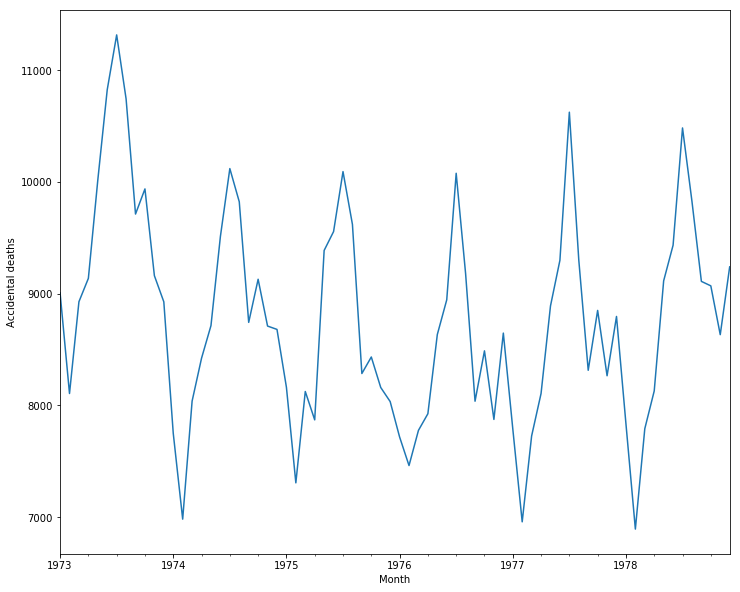

In [2]:
deaths = pd.read_csv('../../data/accidental-deaths-in-usa-monthly.csv',
                   index_col=['Month'], parse_dates=['Month'])
deaths.rename(columns={'Accidental deaths in USA: monthly, 1973 ? 1978': 'num_deaths'}, inplace=True)
deaths['num_deaths'].plot()
plt.ylabel('Accidental deaths');

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.102481


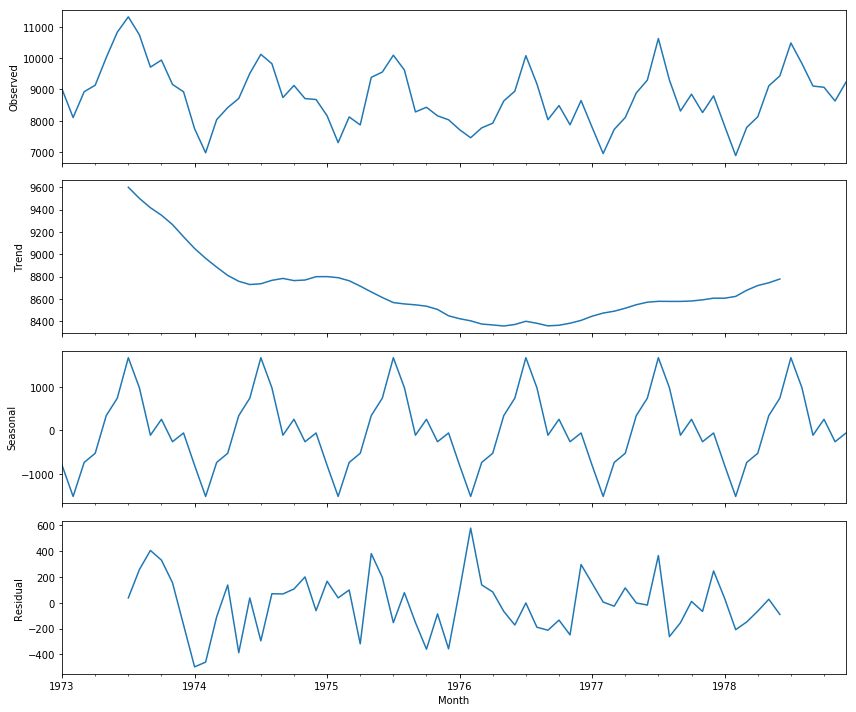

In [3]:
sm.tsa.seasonal_decompose(deaths['num_deaths']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths'])[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, но небольшой тренд остался. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014650


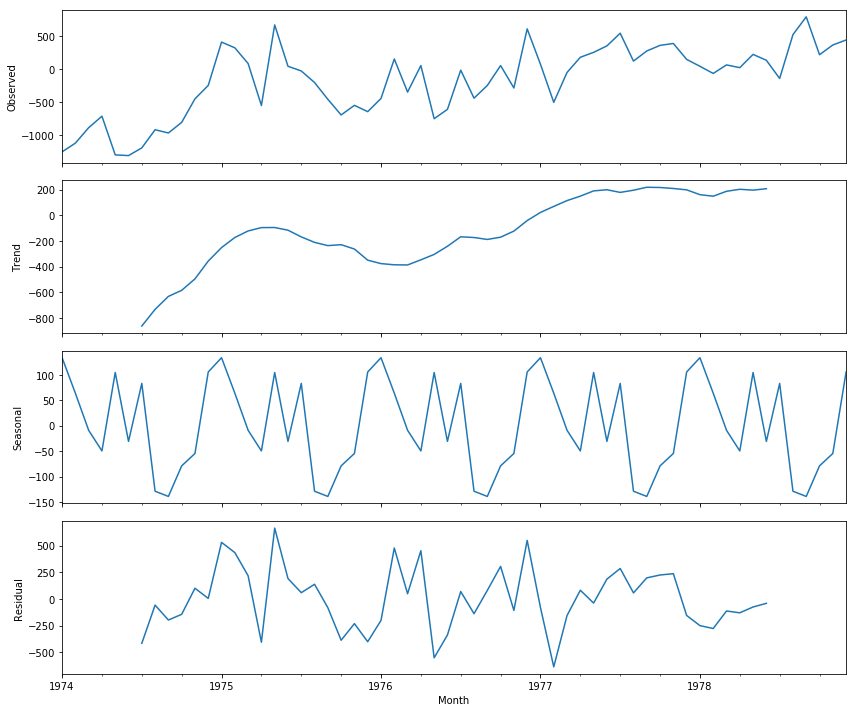

In [4]:
deaths['num_deaths_diff'] = deaths['num_deaths'] - deaths['num_deaths'].shift(12)
sm.tsa.seasonal_decompose(deaths['num_deaths_diff'][12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths_diff'][12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


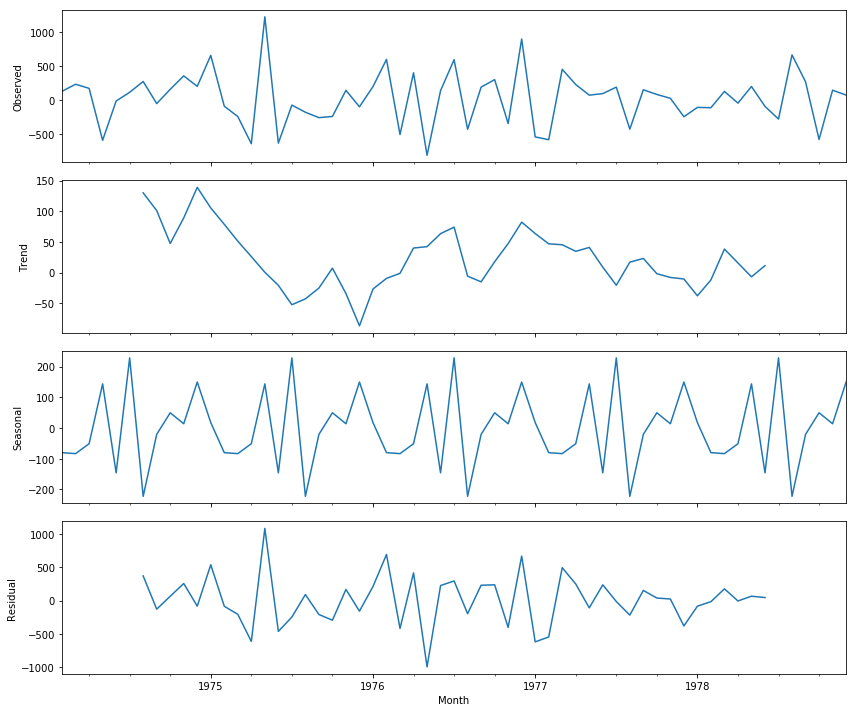

In [5]:
deaths['num_deaths_diff2'] = deaths['num_deaths_diff'] - deaths['num_deaths_diff'].shift(1)
sm.tsa.seasonal_decompose(deaths['num_deaths_diff2'][13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(deaths['num_deaths_diff2'][13:])[1])

Гипотеза нестационарности уверенно отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

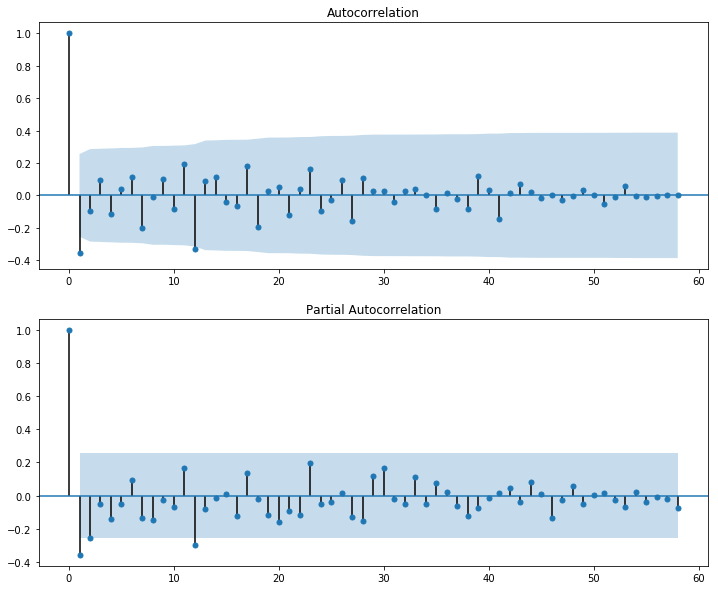

In [6]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(deaths['num_deaths_diff2'][13:].values.squeeze(), lags=58, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(deaths['num_deaths_diff2'][13:].values.squeeze(), lags=58, ax=ax);

Начальные приближения: Q=2, q=1, P=2, p=2

In [7]:
ps = range(0, 3)
d=1
qs = range(0, 1)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [8]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [9]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(deaths['num_deaths'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 0, 0, 2)
wrong parameters: (0, 0, 1, 2)
wrong parameters: (0, 0, 2, 2)
wrong parameters: (1, 0, 0, 2)
wrong parameters: (1, 0, 1, 2)
wrong parameters: (1, 0, 2, 2)
wrong parameters: (2, 0, 0, 2)
wrong parameters: (2, 0, 1, 2)
wrong parameters: (2, 0, 2, 2)
CPU times: user 16.9 s, sys: 382 ms, total: 17.3 s
Wall time: 4.65 s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [10]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
12  (2, 0, 0, 1)  854.647098
6   (1, 0, 0, 1)  855.458079
15  (2, 0, 2, 0)  856.494101
14  (2, 0, 1, 1)  856.614483
9   (1, 0, 2, 0)  856.648917


Лучшая модель:

In [11]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         num_deaths   No. Observations:                   72
Model:             SARIMAX(2, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -423.324
Date:                            Mon, 24 Apr 2017   AIC                            854.647
Time:                                    14:25:12   BIC                            863.754
Sample:                                01-01-1973   HQIC                           858.272
                                     - 12-01-1978                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3724      0.112     -3.329      0.001      -0.592      -0.153
ar.L2         -0.1960      0.170   

Её остатки:

Критерий Стьюдента: p=0.274374
Критерий Дики-Фуллера: p=0.000000


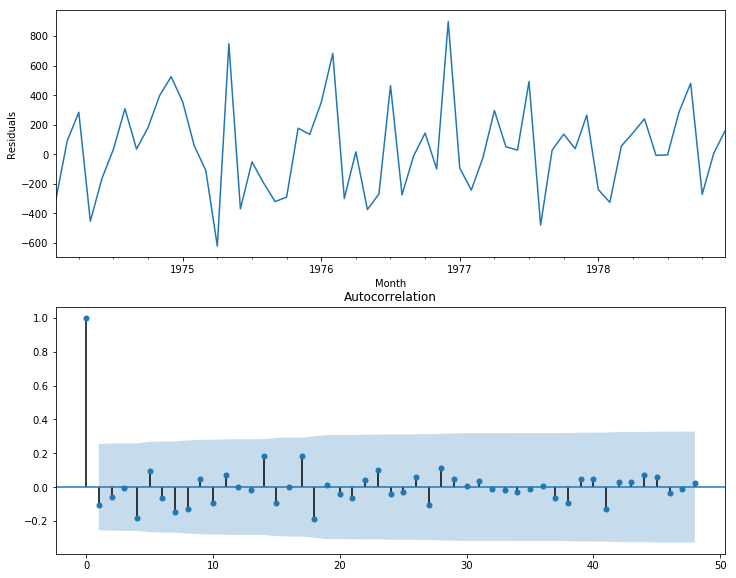

In [12]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента), стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

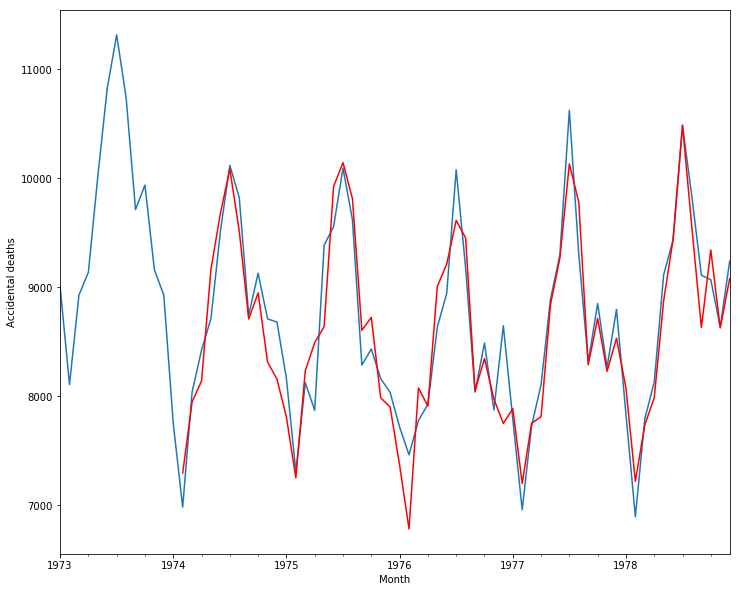

In [13]:
deaths['model'] = best_model.fittedvalues
deaths['num_deaths'].plot()
deaths['model'][13:].plot(color='r')
plt.ylabel('Accidental deaths');

### Прогноз

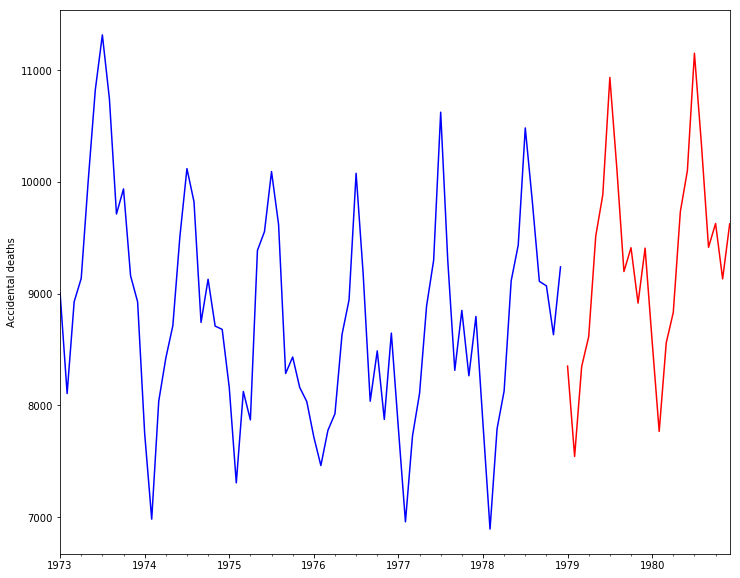

In [14]:
from dateutil.relativedelta import relativedelta
deaths2 = deaths[['num_deaths']]
date_list = [pd.datetime.strptime("1979-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=deaths2.columns)
deaths2 = pd.concat([deaths2, future])
deaths2['forecast'] = best_model.predict(start=72, end=100)

deaths2['num_deaths'].plot(color='b')
deaths2['forecast'].plot(color='r')
plt.ylabel('Accidental deaths');